# Project - Predicting if a customer would subscribe a term deposit

## Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import get_scorer_names

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Loading and Processing Data

In [2]:
df_bank = pd.read_csv('bank-additional-full.csv',sep=';')

### Renaming the Columns

In [3]:
df_bank.columns

df_bank= df_bank.rename(columns={'default':'c_default', 'housing':'h_loan','loan':"p_loan",'contact':'cont_type','month':'lc_month','day_of_week':'lc_day'
               ,'duration':'lc_duration','campaign':'no_of_contact',"pdays":'no_of_day_after_lc','previous':'no_of_contact_prev','emp.var.rate':'emp_var_rate','cons.price.idx':'cons_price_index','cons.conf.idx':'cons_conf_idx','euribor3m':'i_euribor3','nr.employed':'no_employee'})

In [4]:
len(df_bank.columns) #20 Features, 1 Target variable

21

### Deleting Columns

In [5]:
df_bank.drop(['lc_duration'],axis=1,inplace=True)       #Dropping lc_duration column since, y  is automatically known when duration is known (after the call)

In [6]:
df_bank.drop(['c_default'], axis =1, inplace= True) #Dropping c_default column, since there are just 3 records that has credit default 
                                                        #Doesn't add extra information 

In [7]:
len(df_bank.columns)

19

In [8]:
df_bank['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [9]:
df_bank.to_csv('rawdata.csv')

In [10]:
df_bank['age'].value_counts().index.min()

17

In [11]:
df_bank['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Replacing 'unknown' values with mode of the corresponding column

In [12]:
### Replacing 'unknown' values with mode of the corresponding columndf_bank['education'] = [df_bank['education'].mode()[0] if x== 'unknown' else x for x in df_bank['education']]
df_bank['job'] = df_bank['job'].map(lambda x: df_bank['job'].mode()[0] if x == 'unknown' else x)
df_bank['h_loan'] = df_bank['h_loan'].map(lambda x: df_bank['h_loan'].mode()[0] if x == 'unknown' else x)
df_bank['p_loan'] = df_bank['p_loan'].map(lambda x: df_bank['p_loan'].mode()[0] if x == 'unknown' else x)
df_bank['education'] = df_bank['education'].map(lambda x: df_bank['education'].mode()[0] if x == 'unknown' else x)

In [13]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Converting Target Variable to Binary Values

In [14]:
df_bank.index = range(len(df_bank))

df_bank['y'] = [int(1) if x == 'yes' else int(0) for x in df_bank['y']]

df_bank['y'].value_counts()

### Saving Client Data to use in Visualization 

0    36548
1     4640
Name: y, dtype: int64

In [15]:
df_bank['education']

0                   basic.4y
1                high.school
2                high.school
3                   basic.6y
4                high.school
                ...         
41183    professional.course
41184    professional.course
41185      university.degree
41186    professional.course
41187    professional.course
Name: education, Length: 41188, dtype: object

### Label encoding of ordinal education values

In [16]:
education = []
for value in df_bank['education']:
    if value == 'illiterate':
        education.append('1')
    elif value == 'basic.4y':
        education.append('2')         
    elif value == 'basic.6y':
        education.append('3')
    elif value == 'basic.9y':
        education.append('4')
    elif value == 'high.school':
        education.append('5')
    elif value == 'professional.course':
        education.append('6')
    elif value == 'university.degree':
        education.append('7')
df_bank['education'] = education

In [17]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,2,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,5,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,5,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,3,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,5,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,6,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,7,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


### Dropping duplicates

In [18]:
df_bank.drop_duplicates(inplace=True) 

In [19]:
df_bank.to_csv('df_bank.csv')

In [20]:
df_bank.columns

Index(['age', 'job', 'marital', 'education', 'h_loan', 'p_loan', 'cont_type',
       'lc_month', 'lc_day', 'no_of_contact', 'no_of_day_after_lc',
       'no_of_contact_prev', 'poutcome', 'emp_var_rate', 'cons_price_index',
       'cons_conf_idx', 'i_euribor3', 'no_employee', 'y'],
      dtype='object')

### Changing data type of education column

In [21]:
df_bank['education'] = df_bank['education'].astype('int')

In [22]:
df_bank_client = df_bank.iloc[:,:6]
df_bank_client.to_csv('client_data.csv')

In [23]:
df_bank_client

,age,job,marital,education,h_loan,p_loan
0,56,housemaid,married,2,no,no
1,57,services,married,5,no,no
2,37,services,married,5,yes,no
3,40,admin.,married,3,no,no
4,56,services,married,5,no,yes
...,...,...,...,...,...,...
41183,73,retired,married,6,yes,no
41184,46,blue-collar,married,6,no,no
41185,56,retired,married,7,yes,no
41186,44,technician,married,6,no,no


### Separating numerical and categorical data 

In [24]:
df_bank_cat = df_bank.select_dtypes(exclude=np.number)

In [25]:
df_bank_cat

,job,marital,h_loan,p_loan,cont_type,lc_month,lc_day,poutcome
0,housemaid,married,no,no,telephone,may,mon,nonexistent
1,services,married,no,no,telephone,may,mon,nonexistent
2,services,married,yes,no,telephone,may,mon,nonexistent
3,admin.,married,no,no,telephone,may,mon,nonexistent
4,services,married,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...
41183,retired,married,yes,no,cellular,nov,fri,nonexistent
41184,blue-collar,married,no,no,cellular,nov,fri,nonexistent
41185,retired,married,yes,no,cellular,nov,fri,nonexistent
41186,technician,married,no,no,cellular,nov,fri,nonexistent


### One-Hot Encoding 

In [26]:
df_bank_cat_encoded=pd.get_dummies(df_bank_cat, drop_first=True)

In [27]:
df_bank_cat_encoded

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,lc_month_may,lc_month_nov,lc_month_oct,lc_month_sep,lc_day_mon,lc_day_thu,lc_day_tue,lc_day_wed,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
41184,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
41185,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
41186,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


### Concatenating numerical and encoded dataframes 

In [28]:
data_transformed = pd.concat([df_bank_cat_encoded, df_bank.select_dtypes(include=np.number)], axis=1)

In [29]:
data_transformed['y'].value_counts() # There is an imbalance in target feature

0    34486
1     4595
Name: y, dtype: int64

In [30]:
data_transformed

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,education,no_of_contact,no_of_day_after_lc,no_of_contact_prev,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,0,0,1,0,0,0,0,0,0,0,...,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,0,0,0,0,0,0,1,0,0,0,...,5,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,0,1,0,0,0,...,5,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,0,0,0,0,0,0,0,0,0,0,...,3,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,0,0,0,0,0,0,1,0,0,0,...,5,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,1,0,0,0,0,0,...,6,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,1,0,0,0,0,0,0,0,0,0,...,6,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,0,0,0,0,1,0,0,0,0,0,...,7,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,0,0,0,0,0,0,0,0,1,0,...,6,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1


In [31]:
data_transformed['y']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 39081, dtype: int64

### Handling imbalanced Data using SMOTE

In [32]:
smote = SMOTE()

y = data_transformed['y']
X = data_transformed.drop(['y'], axis = 1)

X_sm, y_sm = smote.fit_resample(X, y)


In [33]:
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 39081, dtype: int64

In [34]:
data_transformed['y'].value_counts()

0    34486
1     4595
Name: y, dtype: int64

In [35]:
y_sm    #68972 Data Points after Upsampling

0        0
1        0
2        0
3        0
4        0
        ..
68967    1
68968    1
68969    1
68970    1
68971    1
Name: y, Length: 68972, dtype: int64

## EDA

### Relationship of Age with other Features

In [36]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,2,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,5,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,5,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,3,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,5,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,6,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,7,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [37]:
df_bank['age'].value_counts()

31    1809
32    1746
33    1720
35    1659
36    1653
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64

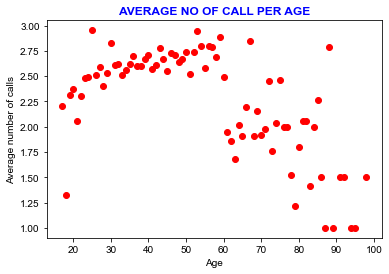

In [38]:



age_freq = df_bank['age'].value_counts()

no_of_tot_cont_per_age = df_bank.groupby(['age'])['no_of_contact'].sum()

no_of_cont_per_age = dict()



for age in age_freq.index:
    freq = age_freq[age]
    tot_con = no_of_tot_cont_per_age[age]
    no_of_cont_per_age[age] = tot_con/freq
    
contact_per_age = no_of_cont_per_age.items()
contact_per_age = sorted(contact_per_age)
x, y = zip(*contact_per_age)


plt.scatter(x, y, c='red')
#sns.scatterplot(x=x,y=y,palette=['red'])

plt.title('AVERAGE NO OF CALL PER AGE', color= 'blue', fontweight='bold')
plt.xlabel("Age")
plt.ylabel("Average number of calls")
sns.set(rc = {'figure.figsize':(12,12)})


In [39]:
positive_response = df_bank[df_bank['y']==1]

pos = positive_response['age'].value_counts()

all_p = df_bank['age'].value_counts()
ratio_of_positive = dict()
for age in pos.index:
    ratio_of_positive[age]= pos[age]/all_p[age]
    



In [40]:
ages = list(ratio_of_positive.keys())


ratio = list(ratio_of_positive.values())

bins = [0,10,20,30,40,50,60,70,80,90,100]

data_tuples = list(zip(ages,ratio))

df_ratio = pd.DataFrame(data_tuples,columns=['ages','ratio'])

df_ratio['bin'] = pd.cut(df_ratio['ages'],bins=range(0,101,10), labels=[f'{l}-{l+10}' for l in range(0,91,10)])



Text(0.5, 1.0, 'Ratio of Customers who accepted the offer per Age Range')

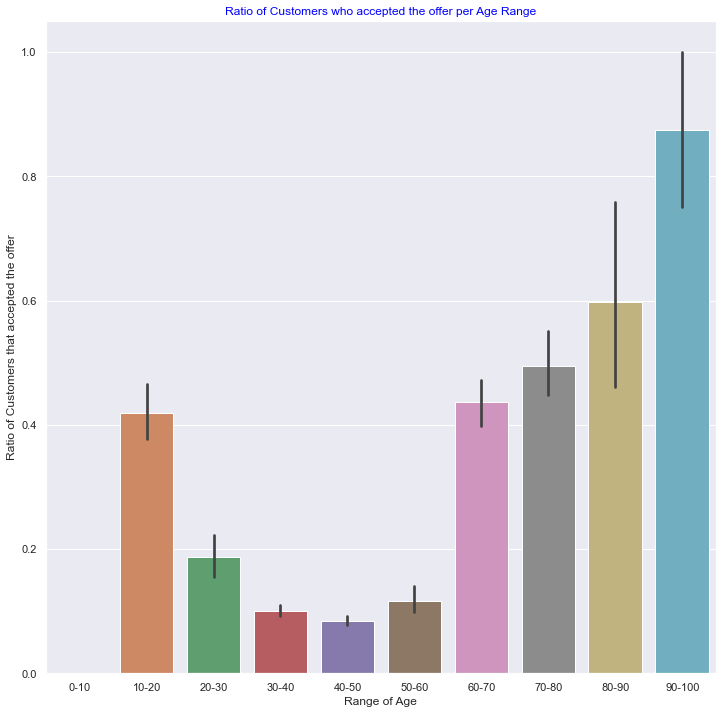

In [41]:
ax = sns.barplot(x=df_ratio['bin'],y=ratio)
ax.set(xlabel='Range of Age',ylabel='Ratio of Customers that accepted the offer')
sns.set(rc={'figure.figsize':(10,10)})

ax.set_title('Ratio of Customers who accepted the offer per Age Range', color='Blue')

In [42]:
df_bank['education']

0        2
1        5
2        5
3        3
4        5
        ..
41183    6
41184    6
41185    7
41186    6
41187    6
Name: education, Length: 39081, dtype: int32

### Effect of Education on Offer Acceptance

In [43]:
education1 = []
for value in df_bank['education']:
    if value == 1:
        education1.append('illeterate')
    elif value == 2:
        education1.append('Primary School')         
    elif value == 3:
        education1.append('Primary School')
    elif value == 4:
        education1.append('Primary School')
    elif value == 5:
        education1.append('High School')
    elif value == 6:
        education1.append('Professional Course')
    elif value == 7:
        education1.append('University Degree')




In [44]:
df_bank_ed = df_bank
df_bank_ed['education'] = education1

In [45]:
df_bank_ed

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,Primary School,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,High School,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,High School,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,Primary School,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,High School,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,Professional Course,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,Professional Course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,University Degree,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,Professional Course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [46]:
df_bank_ed = df_bank_ed.groupby('education')['y'].agg(['count', 'sum'])
df_bank_ed['percentage'] = 100 * df_bank_ed['sum'] / df_bank_ed['count']

In [47]:
df_bank_ed['percentage'] = 100*df_bank_ed['sum']/df_bank_ed['count']

In [48]:
df_bank_ed.index

Index(['High School', 'Primary School', 'Professional Course',
       'University Degree', 'illeterate'],
      dtype='object', name='education')

In [49]:
df_bank_ed.drop(['illeterate'], axis=0,inplace=True)

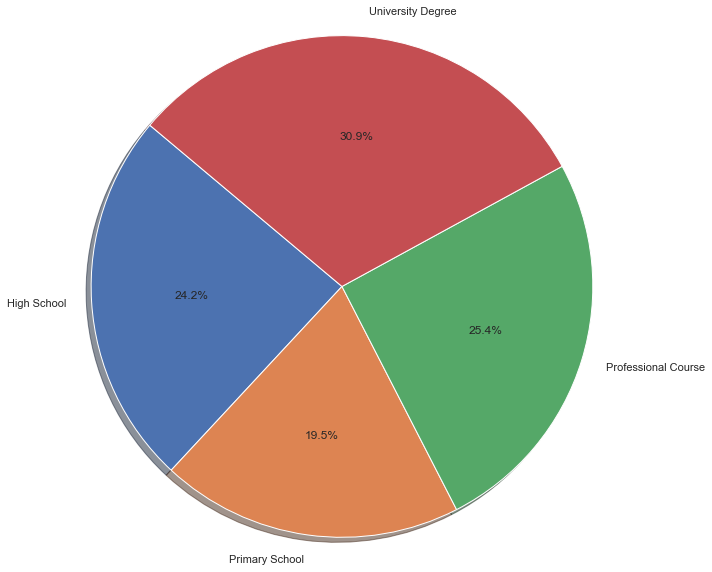

In [50]:
plt.pie(df_bank_ed['percentage'], labels=df_bank_ed.index, 
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Model Comparison

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

model1 = DecisionTreeClassifier()

model2 = LogisticRegression()

model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Decision Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    scores[model_names[i]] = mean_score
    i = i+1
print(scores)

C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'Decision Tree': 0.8793082021541011, 'Logistic Regression': 0.7898094449047225, 'KNN': 0.8346313173156586}


Text(0.5, 1.0, 'Cross Validation Scores of Different Models')

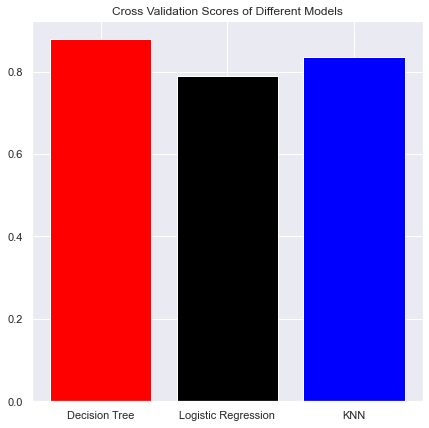

In [52]:
scores_keys = list(scores.keys())
scores_values = list(scores.values())

fig = plt.figure(figsize = (7,7)) 

plt.bar(*zip(*scores.items()),color=['red','black','blue']) 




plt.title('Cross Validation Scores of Different Models')






## Choosing the best Decision Tree depth using cross-validation 

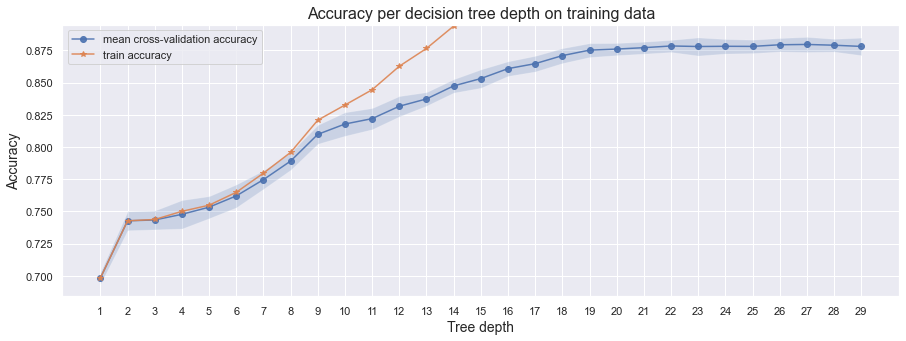

In [53]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,30)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [54]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-27 tree achieves the best mean cross-validation accuracy 87.96603 +/- 0.29467% on training dataset


Best accuracy obtained with a depth of 25. 

## Fitting Decision Tree Classifier

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

model = DecisionTreeClassifier(max_depth=25)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

,Error_metric,Train,Test
0,Accuracy,0.993061,0.887058
1,Precision,0.993878,0.874894
2,Recall,0.992277,0.901382


In [56]:
mean_score = cross_val_score(model, X_test, y_pred_test, scoring="recall", cv = 5).mean()

In [57]:
mean_score

0.8763101921344271

## Fitting Logistic Regression

In [58]:
model1 = LogisticRegression() 

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)
X_test_scaled=std_scaler.transform(X_test)





model1.fit(X_train_scaled, y_train)

y_pred_train = model1.predict(X_train_scaled)
y_pred_test = model1.predict(X_test_scaled)



,Error_metric,Train,Test
0,Accuracy,0.841881,0.840663
1,Precision,0.857451,0.854745
2,Recall,0.821260,0.818049


Confusion matrix for the training set


C:\Users\aykut\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


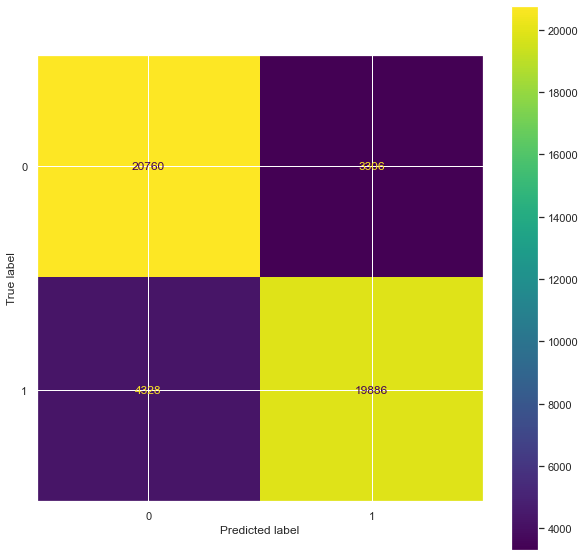

In [59]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

print("Confusion matrix for the training set")



plot_confusion_matrix(model1,X_train_scaled,y_train, values_format='d')
plt.show()

In [60]:
mean_score2 = cross_val_score(model1, X_test, y_pred_test, scoring="recall", cv = 5).mean()

C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [61]:
mean_score2

0.8160903121235897

## KNN Classification

In [62]:
X_train, X_test, y_train, y_test=train_test_split(X_sm, y_sm, test_size=.30,random_state=11)

In [63]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=2,weights='uniform')
model3.fit(X_train, y_train)
y_pred_test=model3.predict(X_test)
y_pred_train=model3.predict(X_train)

In [64]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

,Error_metric,Train,Test
0,Accuracy,0.973467,0.883192
1,Precision,0.999043,0.867503
2,Recall,0.948005,0.902551


In [65]:
mean_score3 = cross_val_score(model3, X_test, y_test, scoring="recall", cv = 5).mean()

In [66]:
mean_score3

0.8289514021658528

## Feature Selection

### Recursive Feature Elimination

In [67]:
y_train

62251    1
59261    1
46167    1
50874    1
53730    1
        ..
30369    0
57676    1
21584    0
36543    0
10137    0
Name: y, Length: 48280, dtype: int64

In [68]:


model = DecisionTreeClassifier(max_depth=25)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

rfecv = RFECV(estimator=DecisionTreeClassifier(max_depth=25), 
              step=1, 
              cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X_train, y_train)



print("Optimum number of features: %d" % rfecv.n_features_)




selected_features = rfecv.get_support(1)
selected_features

X_selected_train = X_train[X_train.columns[selected_features]]                  #Dropping Statistically insignificant Columns
X_selected_test = X_test[X_test.columns[selected_features]]                     


Optimum number of features: 23


In [69]:
y_train = y_train[X_selected_train.index]


C:\Users\aykut\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


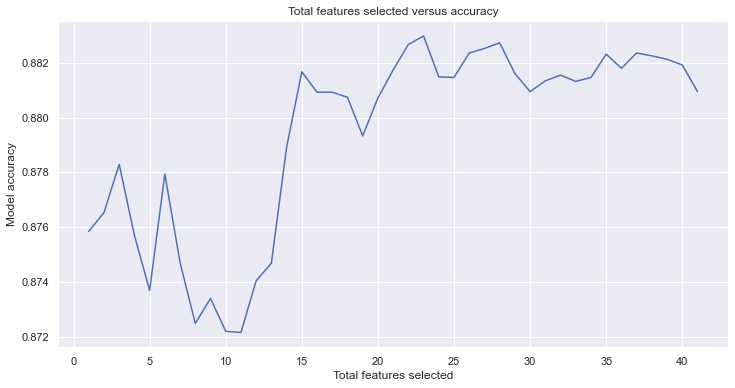

In [70]:
plt.figure( figsize=(12, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
scores = []
for i in rfecv.grid_scores_:
    score = i.mean()
    scores.append(score)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), scores)
plt.show()

<AxesSubplot:ylabel='columns_name'>

<Figure size 1440x1008 with 0 Axes>

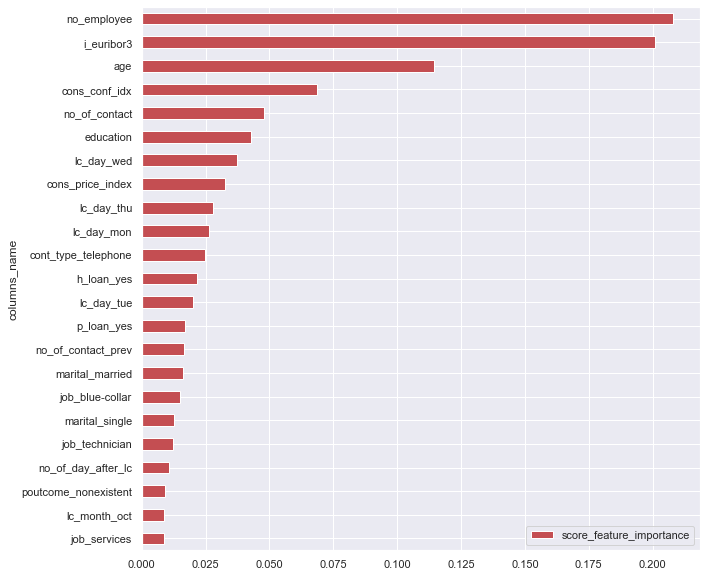

In [71]:
model.fit(X_selected_train,y_train)

feature_names = X_selected_train.columns
feature_names = list(feature_names)

df = pd.DataFrame(list(zip(feature_names, model.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df=df.sort_values(by=['score_feature_importance'], ascending = True)


plt.figure(figsize=(20,14))
df.plot(kind='barh',y='score_feature_importance',x='columns_name',color='r')


### Feature Importance

## Random Forest Hyper Parameter Tuning 

In [72]:

# param_grid = {
#     'n_estimators': [50, 100,500],
#     'min_samples_split': [2, 4],
#     'min_samples_leaf' : [1, 2],
#     'max_features': ['sqrt'],
#     #'max_samples' : ['None', 0.5],
#     #'max_depth':[3,5,10],
#      #'bootstrap':[True,False] 
#     }
# clf = RandomForestClassifier(random_state=100)

# grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

# grid_search.fit(X_selected_train,y_train)

In [75]:
#grid_search.best_params_


In [74]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=500)
cross_val_scores = cross_val_score(clf, X_selected_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.9140223695111848


In [ ]:
get_scorer_names()

## Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

In [ ]:
X_selected_train = X_train[X_train.columns[selected_features]]                  #Dropping Statistically insignificant Columns
X_selected_test = X_test[X_test.columns[selected_features]] 

In [ ]:
y_train = y_train[X_selected_train.index]


In [ ]:
y_train

In [ ]:
cv_accuracy_train = cross_val_score(clf, X_selected_train, y_train, cv=10,scoring='accuracy').mean()
cv_recall_train= cross_val_score(clf,X_selected_train,y_train,cv=10,scoring='recall').mean()
cv_prec_train = cross_val_score(clf,X_selected_train,y_train,cv=10,scoring='precision').mean()


cv_accuracy_test = cross_val_score(clf, X_selected_test, y_test, cv=10,scoring='accuracy').mean()
cv_recall_test= cross_val_score(clf,X_selected_test,y_test,cv=10,scoring='recall').mean()
cv_prec_test = cross_val_score(clf,X_selected_test,y_test,cv=10,scoring='precision').mean()

In [ ]:
Scores_training = [cv_accuracy_train,cv_prec_train, cv_recall_train]
Scores_test = [cv_accuracy_test,cv_prec_test,cv_recall_test]

labels = ['accuracy', 'precision', 'recall']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, Scores_training, width, label='Training')
rects2 = ax.bar(x + width/2, Scores_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Cross Validation Scores')
ax.set_xticks(x, labels)
ax.legend(loc=5, prop={'size': 10})

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
with open("clf.pickle", "wb") as file:
    pickle.dump(clf, file)

In [ ]:
with open("clf.pickle", "rb") as file:
    model = pickle.load(open("clf.pickle", "rb"))

### Confusion Matrix

In [ ]:
clf.fit(X_selected_train,y_train)

plot_confusion_matrix(clf,X_selected_train,y_train, values_format='d')
plt.grid(False)
plt.show()

In [ ]:


plot_confusion_matrix(clf,X_selected_test,y_test, values_format='d')
plt.grid(False)
plt.show()